In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib notebook
from pylab import *
from iris.pandas import as_cube, as_series, as_data_frame

Add fire_total column to dataframe, which sums all wildfires in particular latitude/longitude, (corrected to 2 decimal places), for a particular year and month

In [2]:
def create_wildfire_df(PATH):
    '''
    PATH: Linux path to sqlite for wildfire database
    Output:
        dataframe: of wildfire with the following columns:
        LATITUDE
        LONGITUDE
        STATE
        date
        fire_size
        fire_year
        fire_month
        fire_total (This is total fire in a particular latitude, longitude, fire_year and fire_month)
    '''
    assert(os.path.exists(PATH)),"Incorrect file path"
    conn = sqlite3.connect(PATH)
    data_dates = pd.read_sql_query("SELECT fire_year, discovery_date FROM fires;", conn)
    data_size = pd.read_sql_query("SELECT fire_size, fire_size_class FROM fires;", conn)
    data_location = pd.read_sql_query("SELECT latitude, longitude, state FROM fires;", conn)
    date = pd.read_sql_query("select datetime(DISCOVERY_DATE) as DISCOVERY_DATE from fires;", conn)
    data_dates_arr = date['DISCOVERY_DATE']
    fire_year_arr = data_dates['FIRE_YEAR']
    fire_size_arr = data_size['FIRE_SIZE']  
    #Create a dataframe df 
    df = data_location
    df['date'] = data_dates_arr
    df['fire_size'] = fire_size_arr
    df['fire_year'] = fire_year_arr
    df['fire_month'] = pd.DatetimeIndex(df['date']).month
    #Converted Lat and Long to int to remove the exact precision
    df['LATITUDE'] = df['LATITUDE'].round(2)
    df['LONGITUDE'] = df['LONGITUDE'].round(2)
##Compute total fire based on Latitude, Longitude, fire_year and fire_month
    df['fire_total'] = df.groupby(['LATITUDE','LONGITUDE', 'fire_year','fire_month'])['fire_size'].transform(sum)
    
    return df

In [3]:
def large_fire_coord(state, fire_size, df):
    '''
    Function: Extact locations for very large wildfires
    Input: 
        state: The state we want to focus on.
        df: Input dataframe
        fire_size: fire size above which is considered large
    Output:
        lat_min,lat_max,long_min,long_max: the coordinates with fires above fire_size in state 'state'
    '''
    #print(state)
    df = df.query("fire_total >= fire_size and STATE == @state")
    lat_max = df['LATITUDE'].max()
    lat_min = df['LATITUDE'].min()
    long_max = df['LONGITUDE'].max()
    long_min = df['LONGITUDE'].min() 
    return lat_min,lat_max,long_min,long_max

In [4]:
#create fire_df which is a dataframe containing all wildfire information
PATH = '../../188-million-us-wildfires/FPA_FOD_20170508.sqlite'
fire_df = create_wildfire_df(PATH)

In [5]:
# ##Returns fire_sz 
# def process_df(coords, df):
#     '''
#     Input: 
#         coords: A tuple of lat_min,lat_max,long_min,long_max in which we need to find wild fires
#         Find sum of fire occuring within the location, for a given year and month
    
#     '''
#     lat_min,lat_max,long_min,long_max = coords
#     #print(lat_min,lat_max,long_min,long_max)
#     df_new = df.query("LATITUDE >= @lat_min and LATITUDE <= @lat_max and LONGITUDE >= @long_min and LONGITUDE <= @long_max")
#     #print(df_new)
#     df_new['fire_total_area'] = df_new.groupby(['fire_year','fire_month'])['fire_total'].transform(sum)
#     df_new = df_new.sort_values('fire_total', ascending=False).drop_duplicates(['fire_year','fire_month'])
#     df_final = df_new[['fire_year','fire_month','fire_total_area']]
#     return df_final
def process_df(coords, fire_size, df,year):
    '''
    Input: 
        coords: A tuple of lat_min,lat_max,long_min,long_max in which we need to find wild fires
        Find sum of fire occuring within the location, for a given year and month
        output: (fire_sz,latitudes,longitudes), with area burnt in a particular location, fire size larger than  a large fire, and particular fire year
    '''
    lat_min,lat_max,long_min,long_max = coords
    print("Inital", len(df))
    #print(lat_min,lat_max,long_min,long_max)
    df_new = df.query("LATITUDE >= @lat_min and LATITUDE <= @lat_max and LONGITUDE >= @long_min and LONGITUDE <= @long_max and fire_total>=@fire_size and fire_year == @year")
    print("Particular Year & location", len(df_new))
    df_new['fire_total_month'] = df_new.groupby(['LATITUDE','LONGITUDE', 'fire_year'])['fire_total'].transform(sum)    
    df_new = df_new.sort_values('fire_total', ascending=False).drop_duplicates(['fire_total_month'])
    print("Sum over months in year", len(df_new))
    fire_sz= np.array(df_new['fire_total_month'].to_list())
    lat_fire = np.array(df_new['LATITUDE'].tolist())
    lon_fire = np.array(df_new['LONGITUDE'].tolist())+360
    return fire_sz,lat_fire,lon_fire

In [6]:
###Get coordinates where fires are really large only.. In state of AK.
coords = large_fire_coord('AK',10000,fire_df)
#fire_df_local = process_df(coords,100,fire_df,2004)

In [7]:
fire_sz,l,ll = process_df(coords,100,fire_df,2004)

Inital 1880465
Particular Year & location 123
Sum over months in year 121


C:\Users\payal\Anaconda4\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
coords

(51.53, 70.33, -178.8, -130.05)

In [9]:
import os 
import numpy as np
import iris   
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline
import iris.coord_categorisation as cat
import pandas as pd
from iris.analysis import Aggregator

In [10]:
def region_based_cube(cube,coords):
    '''
    Inputs:
        cube with latitude and longitude as coords
        coords: the region we want to extract from input cube
    Outputs: 
        A smaller cube within coords
    '''
    lat_min,lat_max,long_min,long_max = coords
    lat_cons = iris.Constraint(latitude = lambda x : lat_min < x < lat_max)
    if (long_min<0):
        long_min = long_min+360
    if(long_max <0) :
        long_max = long_max+360
    long_cons = iris.Constraint(longitude = lambda x : long_min < x < long_max)
    new_cube = cube.extract(lat_cons & long_cons)
    return new_cube

In [11]:
def time_based_cube(cube,year):
    time_cons = iris.Constraint(year = year)
    new_cube = cube.extract(time_cons)
    return new_cube

In [12]:
##Adding auxilary axis:
def get_decade(coord, value):
    date = coord.units.num2date(value)
    return date.year - date.year % 10
def get_year(coord, value):
    date = coord.units.num2date(value)
    return date.year

def get_month(coord, value):
    date = coord.units.num2date(value)
    return date.month


In [13]:
##Create cube_local which is cube extracted for same coords as wildfire.
PATH_temp = os.path.join(os.getcwd(), "../../air.mon.mean.nc")
cube_temp = iris.load_cube(PATH_temp)
cat.add_categorised_coord(cube_temp, 'year', 'time', get_year)
cat.add_categorised_coord(cube_temp, 'month', 'time', get_month)
cube_local = region_based_cube(cube_temp,coords)


In [14]:
##Get the cube for a particular year. It takes maximum temperature seen in that year
def get_cube_data(cube,year):
    cube_time = time_based_cube(cube,year)
    cube_mean = cube_time.collapsed(['month'], iris.analysis.MAX)
    lat = cube_mean.coord('latitude').points
    lon = cube_mean.coord('longitude').points
    return cube_mean.data,lat,lon

In [15]:
data,lat,lon=get_cube_data(cube_local,2004)

C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [16]:
print(min(lat),max(lat),min(lon),max(lon))


51.75 70.25 181.25 229.75


C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Inital 1880465
Particular Year & location 123
Sum over months in year 121


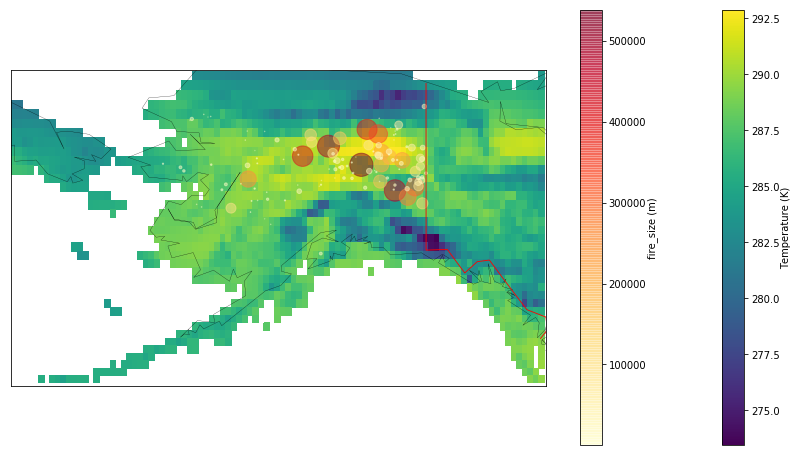

In [17]:
##Plot showing temperature with wildfire size for 2004. 
##Size of circles denote and color denote area burnt due to wildfire.
#%matplotlib notebook

#def create_map(year):
year = 2004
plt.figure(figsize=[15,8])
#fig, ax = plt.subplots(figsize=(10, 4))
#fig, ax = plt.subplots()
m=Basemap(projection='mill',lat_ts=10, \
  llcrnrlon=coords[2]+360,urcrnrlon=coords[3]+360, \
  llcrnrlat=coords[0],urcrnrlat=coords[1], \
  resolution='c')
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.85,color='red')
data,lat,lon=get_cube_data(cube_local,year)
Lon,Lat = meshgrid(lon,lat)
x, y = m(Lon,Lat)
cs = m.pcolormesh(x,y,data,shading='flat',cmap='viridis')
#print("CS..",type(cs))
cbar= plt.colorbar()
cbar.set_label("Temperature (K)", labelpad=+1)
fire_sz,lat_fire,lon_fire = process_df(coords,100,fire_df,year)
a,b = m(lon_fire,lat_fire)
scat = m.scatter(lon_fire, lat_fire, s=fire_sz/1000, latlon=True,
         c=fire_sz,cmap='YlOrRd',
          alpha=0.5)
cbar= plt.colorbar()
cbar.set_label("fire_size (m)", labelpad=+1)
plt.show()


# %matplotlib notebook
# interactive_plot = interactive(create_map, year=(1992,2012,1))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

# Time Series Analysis

In [18]:
def process_df_local(coords, df):
    '''
    Input: 
        coords: A tuple of lat_min,lat_max,long_min,long_max in which we need to find wild fires
        Find sum of fire occuring within the location, for a given year and month
    
    '''
    lat_min,lat_max,long_min,long_max = coords
    #print(lat_min,lat_max,long_min,long_max)
    df_new = df.query("LATITUDE >= @lat_min and LATITUDE <= @lat_max and LONGITUDE >= @long_min and LONGITUDE <= @long_max")
    #print(df_new)
    df_new['fire_total_area'] = df_new.groupby(['fire_year','fire_month'])['fire_total'].transform(sum)
    df_new = df_new.sort_values('fire_total_area', ascending=False).drop_duplicates(['fire_year','fire_month'])
    df_final = df_new[['fire_year','fire_month','fire_total_area']]
    return df_final

In [19]:
fire_time_based = process_df_local(coords,fire_df)
fire_time_based = fire_time_based.rename(columns={"fire_year": "year", "fire_month": "month"})

C:\Users\payal\Anaconda4\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [20]:
PATH_temp = os.path.join(os.getcwd(), "../../air.mon.mean.nc")
cube_temp = iris.load_cube(PATH_temp)
cube_local = region_based_cube(cube_temp,coords)

In [21]:
cube_max = cube_local.collapsed(['latitude','longitude'], iris.analysis.MAX)

C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [22]:
df = as_data_frame(cube_max, copy=True)
df = df.reset_index()
df['month'] = pd.DatetimeIndex(df['index']).month
df['year'] = pd.DatetimeIndex(df['index']).year
df.drop('index',axis=1,inplace=True)
df = df.rename(columns={0:"Temperature"})
df = df.query("year >= 1992 and year <=2015")


In [23]:
result1 = pd.merge(df, fire_time_based, on=['year', 'month'],how='left')
result1.fillna(0,inplace=True)

In [24]:
#result1['fire_total_area'].max()

In [25]:
def create_plt(month):
    temp = result1[result1['month'] == month]['Temperature'].tolist()
    area = result1[result1['month'] == month]['fire_total_area'].tolist()
    m_temp = [mean(temp)]*len(temp)
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.set_ylabel('Area')
    ax1.set_xlabel('Years')
    ax1.set_ylim([0,5000000])
    ax1.plot(area,color='r',label='Area')
    ax2 = ax1.twinx()
    ax2.set_ylabel("Temp")
    #ax2.set_ylim(270,300)
    ax2.plot(temp,label="Temp")
    ax2.plot(m_temp,label="Mean")
    fig.tight_layout()
    plt.legend()
    plt.show()
#plt.close

In [27]:
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
interactive_plot = interactive(create_plt, month=(1,12,1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=6, description='month', max=12, min=1), Output(layout=Layout(height='350…

In [ ]:
coords